<a href="https://colab.research.google.com/github/itsGab/previsao_uti_em_covid/blob/main/previsao_uti_em_covid/notebooks/1_ANALISE_entendendo_os_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'> Previsão de Admissão na UTI por COVID-19 </h1>
<h2 align='center'> Notebook De Análise Exploratória </h2>

# IMPORTAÇÕES (data & libs)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import missingno as msno

# importação dos dados
data_raw = 'https://github.com/itsGab/previsao_uti_em_covid/blob/main/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

# ABRINDO O CONJUNTO DE DADOS


Este **conjunto de dados** contém dados anônimos do Hospital Sírio-Libanês, São Paulo e Brasília. Todos os dados foram tornados anônimos de acordo com as melhores práticas e recomendações internacionais. Os dados foram limpos e escalados por coluna de acordo com o Min Max Scaler para caber entre -1 e 1.


In [2]:
# lendo os dados com pandas
df = pd.read_excel(data_raw)

# removendo espaco no nome das colunas
df.columns = df.columns.str.replace(' ', '_')

# mostrando o formato e tamanho do dataframe
print(f'formato: {df.shape}')
print(f'tamanho: {df.size}')

# mostrando o cabeçalho do dataframe
df.head()

formato: (1925, 231)
tamanho: 444675


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE_GROUPING_1,DISEASE_GROUPING_2,DISEASE_GROUPING_3,DISEASE_GROUPING_4,DISEASE_GROUPING_5,DISEASE_GROUPING_6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

Nessa exibição inicial é possível ver o formato do dataframe, com o qual estamos trabalhando 

| Formato | Descrição |
|--|--|
| Linhas | 1925 |
| Colunas | 231 |

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


<h3 align='center'> Informações: </h3>

| Info | Descrição |
|--|--|
| Nº de colunas | 231 |
| Nº de linhas | 1925 | 
| Data types| ["float64(225)", "int64(4)", "object(2)"] |
| Nº de pacientes | 385 | 

# VALORES FALTANTES

### Porcentagem total de valores faltantes

In [4]:
df.isnull().sum().sum()/df.size

0.5034305953786473

Os valores faltantes (ou vazios, NaN), representam 50.34 % da nossa base de dados.

### Matrix de valores faltantes

Plotando matrix de valor faltantes (missing values), referente a uma amostra de 10% dos dados. 

*Obs.: Os valores escuros são os valores presentes.*

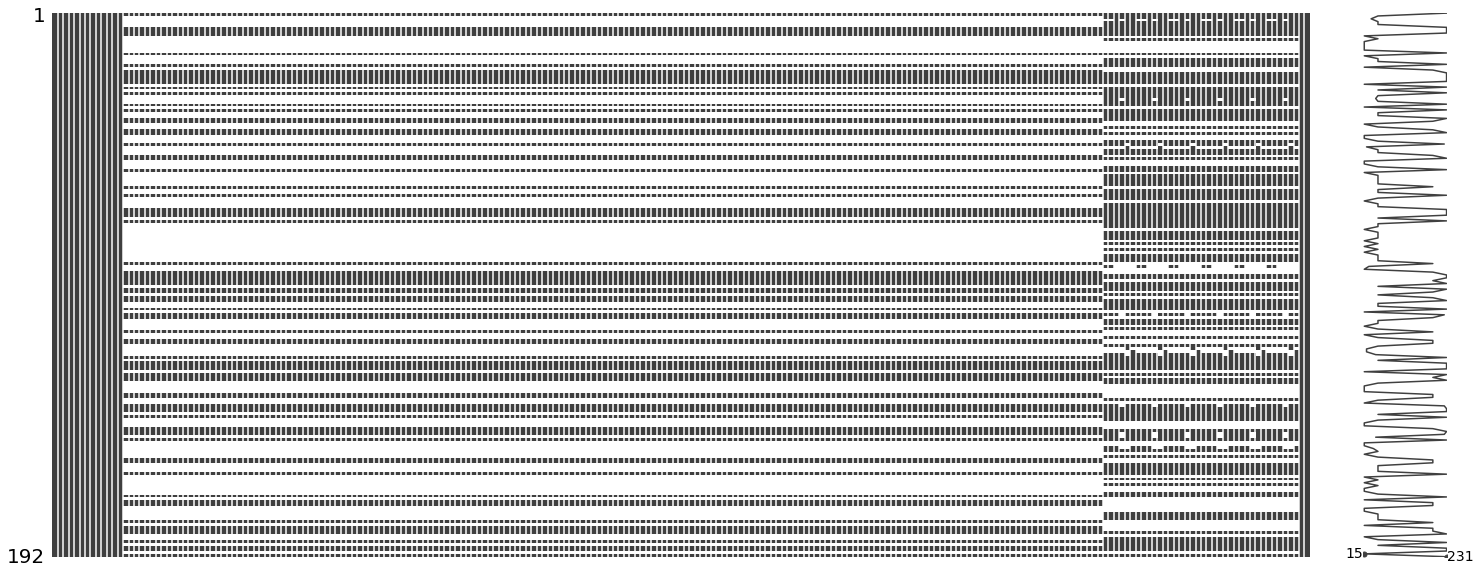

In [5]:
%matplotlib inline
msno.matrix(df.sample(frac=.1))

### Quantidade de valores faltantes por colunas

In [6]:
df.isnull().sum().sort_values(ascending=False)

P02_VENOUS_MIN              1104
HEMOGLOBIN_MEAN             1104
LACTATE_MIN                 1104
LACTATE_MEAN                1104
LACTATE_MEDIAN              1104
                            ... 
AGE_ABOVE65                    0
ICU                            0
GENDER                         0
WINDOW                         0
PATIENT_VISIT_IDENTIFIER       0
Length: 231, dtype: int64

# SEPARAÇÃO DE COLUNAS POR TIPO

As colunas podem ser categorizadas em 5 principais tipos, sendo elas: 

* Colunas informativas: são essa o identificador do paciente, a janela de tempo e se o paciente foi ou não admitido na UTI. 

* Colunas de demograficas: representam informações como sexo ou idade do paciente.

* Colunas de comorbidades: representam algum grupo de doença ou comorbidades que o paciente venha ou nao a ter.

* Colunas de sinais vitais: representam resultados de sinais vitais do paciente

* Colunas de exames laboratoriais: representam resultados de exames laboratorias feitos no paciente.



Fazendo a separação das colunas em lista por tipo e salvando em CSV para consulta

In [7]:
# Baseado em um notebook feito pelo criador do desafio
# https://www.kaggle.com/felipeveiga/starter-covid-19-sirio-libanes-icu-admission

# informativas
cols_informativas = ["PATIENT_VISIT_IDENTIFIER", "WINDOW", "ICU"]

# demograficas
cols_demograficas = [i for i in df.columns if "AGE_" in i]
cols_demograficas.append("GENDER")

# comorbidades
cols_comorbidades = [i for i in df.columns if "DISEASE" in i]
cols_comorbidades.extend(["HTN", "IMMUNOCOMPROMISED", "OTHER"])

# sinais vitais
cols_sinais_vitais = df.iloc[:,193:-2].columns.tolist()

# exames laboratoriais
cols_exames_laboratoriais = df.iloc[:,13:193].columns.tolist()

# criando uma Series para consulta
s_colunas = pd.Series(data={'informativas': cols_informativas,
                            'demograficas': cols_demograficas,
                            'comorbidades': cols_comorbidades,
                            'sinais_vitais': cols_sinais_vitais,
                            'exames_laboratoriais': cols_exames_laboratoriais}, 
                      name = 'Colunas_por_tipo')

# salvando em arquivo CSV
s_colunas.to_csv('Colunas_por_tipo')

# COLUNAS INFORMATIVAS

## COLUNAS

In [8]:
df[cols_informativas][:7]

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1
5,1,0-2,1
6,1,2-4,1


As colunas informativas são compostas:

| Colunas | Descrição |
| -- | -- |
| PATIENT_VISIT_IDENTIFIER | Identificador do paciente |
| WINDOW| Janela de tempo |
| ICU | Variável de admissão na UTI |

### **IDENTIFICADOR DE PACIENTE**

In [9]:
df['PATIENT_VISIT_IDENTIFIER'].nunique()

385

A Coluna '**PATIENT_VISIT_IDENTIFIER**' é composta por **385** pacientes de identificador único, indo de 0 à 384. Cada identificador **aparece** 5 vezes, dentro do conjunto de dados, devido as **5 janelas de admissão**.

### **WINDOW**

In [10]:
df['WINDOW'].unique()

array(['0-2', '2-4', '4-6', '6-12', 'ABOVE_12'], dtype=object)

A Coluna **'WINDOW'** foi divida em 5 janelas de admissão na UTI.

| Window | Descrição |
|--|--|
| 0-2 | De 0 á 2 horas da admissão |
| 2-4 | De 2 a 4 horas da admissão |
| 4-6 | De 4 a 6 horas da admissão |
| 6-12 | De 6 a 12 horas da admissão |
| Above_12 | Acima de 12 horas da admissão |

### **UTI**

In [11]:
df['ICU'].unique()

array([0, 1])

A variável **UTI**, representada por **'ICU'**, é a nossa variável alvo, ou seja, a variável da qual queremos prever no modelo de *Machine Learning*. 

Seus valores são booleanos (Verdadeiro: 1, Falso: 0), representando a admissão ou não admissão na UTI.

| ICU | Descrição |
|--|--|
| 0 | Não teve admissão na UTI |
| 1 | Teve admissão na UTI |

# COLUNAS DEMOGRÁFICAS


## COLUNAS

In [12]:
df[cols_demograficas].head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER
0,1,60th,0
1,1,60th,0
2,1,60th,0
3,1,60th,0
4,1,60th,0


As colunas demográficas são compostas:

| Colunas | Descrição |
| -- | -- |
| AGE_ABOVE65 | Acima de 65 anos |
| AGE_PERCENTIL | Percentil de idade |
| GENDER | Sexo (masculino ou feminino) |

### **IDADE ACIMA DE 65 ANOS**


In [13]:
df['AGE_ABOVE65'].unique()

array([1, 0])

|AGE_ABOVE65|Descrição|
|--|--|
|0|Idade menor ou igual a 65 anos|
|1|Idade acima de 65 anos|

### **PERCENTIS DE IDADE**



In [14]:
sorted(df['AGE_PERCENTIL'].unique().tolist())

['10th',
 '20th',
 '30th',
 '40th',
 '50th',
 '60th',
 '70th',
 '80th',
 '90th',
 'Above 90th']

### **GÊNERO**


In [15]:
df['GENDER'].unique()

array([0, 1])

| GENDER | Descrição |
|--|--|
| 1 | Feminino |
| 0 | Masculino |

# COLUNAS DE COMORBIDADES

## COLUNAS

In [16]:
df[cols_comorbidades]

,DISEASE_GROUPING_1,DISEASE_GROUPING_2,DISEASE_GROUPING_3,DISEASE_GROUPING_4,DISEASE_GROUPING_5,DISEASE_GROUPING_6,HTN,IMMUNOCOMPROMISED,OTHER
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


As colunas identificadas como comorbidades, tem valores _booleanos_, identificando se o paciente, em questão, tem ou não a comorbidade.

| Valor | Descrição |
|--|--|
| 1 | Possui (Verdadeiro)|
| 0 | Não possui (Falso) |

### DESCRIÇÃO

| COMORBIDADES | Descrição|
|--|--|
| DISEASE_GROUPING | Doenças Agrupadas |
| HTN | Hipertensão |
| IMMUNOCOMPROMISED | Imunocomprometido |
| OTHER | Outras |

### DOENÇAS AGRUPADAS

In [17]:
d_agrupadas = [col for col in df[cols_comorbidades].columns if 'DISEASE_GROUPING' in col]
d_agrupadas

['DISEASE_GROUPING_1',
 'DISEASE_GROUPING_2',
 'DISEASE_GROUPING_3',
 'DISEASE_GROUPING_4',
 'DISEASE_GROUPING_5',
 'DISEASE_GROUPING_6']

Para melhorar a privacidade de paciente é feita uma agrupamento das doenças. Esses agrupamento foram divididos em 6 grupos sem identificação das doenças contidas neles.

# COLUNAS SINAIS VITAIS E EXAMES LAB.

## INFORMAÇÕES

|Colunas| Quantidade|
|--|--|
|Sinais Vitiais| 6 |
|Exames Laboratoriais| 36 |

As colunas de exames são expandidas em **média, mediana, máxima, mínima, diferença e diferença relativa**.

Os números forma escalados por coluna de acordo com o Min Max Scaler para caber entre **-1 e 1**.

## SINAIS VITAIS

As colunas de **sinais vitais** são divida em 6 diferentes, no total são 36 colunas com suas variações.

In [18]:
df[cols_sinais_vitais].head()

,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000
4,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433


In [19]:
df[cols_sinais_vitais].describe()

,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
count,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000
mean,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982
std,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.262708,-0.523077,-0.420791,-0.552542,-0.102991,0.684211,-0.283951,-0.538462,-0.433962,-0.517241,-0.107143,0.684211,-0.195876,-0.375000,-0.452991,-0.642857,0.186813,0.818182,-0.418803,-0.578378,-0.477612,-0.575758,-0.188406,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-0.100172,-0.374405,-0.283019,-0.502825,0.035714,0.736842,-0.135802,-0.384615,-0.283019,-0.517241,0.035714,0.736842,-0.030928,-0.250000,-0.282051,-0.500000,0.318681,0.878788,-0.247863,-0.459459,-0.328358,-0.454545,-0.014493,0.842105,-1.000000,-0.987730,-0.984733,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333
75%,0.086420,-0.184615,-0.132075,-0.383289,0.205890,0.823995,0.086420,-0.200000,-0.132075,-0.379310,0.196429,0.842105,0.175258,-0.050000,-0.094017,-0.357143,0.472527,0.919192,-0.076923,-0.243243,-0.119403,-0.212121,0.217391,0.894737,-0.565217,-0.558282,-0.541985,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## EXAMES LABORATORIAIS

As colunas de **exames laboratoriais** são divida em 36 diferentes, no total são 180 colunas com suas variações.

In [20]:
df[cols_exames_laboratoriais].head()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,...,0.939394,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,-0.028571,-0.028571,-0.028571,-0.028571,-1.0,-0.997201,-0.997201,-0.997201,-0.997201,-1.0,-0.990854,-0.990854,-0.990854,-0.990854,-1.0,-0.825613,-0.825613,-0.825613,-0.825613,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,-0.979069,-0.979069,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-1.0,...,0.848485,0.848485,0.848485,0.848485,-1.0,0.925926,0.925926,0.925926,0.925926,-1.0,0.142857,0.142857,0.142857,0.142857,-1.0,-0.999067,-0.999067,-0.999067,-0.999067,-1.0,-0.983994,-0.983994,-0.983994,-0.983994,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.996762,-0.996762,-0.996762,-0.996762,-1.0


In [21]:
df[cols_exames_laboratoriais].describe()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
count,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,...,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0
mean,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,-0.945928,-1.0,-0.994424,-0.994424,-0.994424,-0.994424,-1.0,0.330359,0.330359,0.330359,0.330359,-1.0,...,0.914277,0.914277,0.914277,0.914277,-1.0,0.331965,0.331965,0.331965,0.331965,-1.0,-0.053060,-0.053060,-0.053060,-0.053060,-1.0,-0.991054,-0.991054,-0.991054,-0.991054,-1.0,-0.982156,-0.982156,-0.982156,-0.982156,-1.0,-0.822280,-0.822280,-0.822280,-0.822280,-1.0,-0.830181,-0.830181,-0.830181,-0.830181,-1.0,-0.954177,-0.954177,-0.954177,-0.954177,-1.0
std,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,0.076610,0.0,0.098000,0.098000,0.098000,0.098000,0.0,0.126224,0.126224,0.126224,0.126224,0.0,...,0.149537,0.149537,0.149537,0.149537,0.0,0.305148,0.305148,0.305148,0.305148,0.0,0.205937,0.205937,0.205937,0.205937,0.0,0.074863,0.074863,0.074863,0.074863,0.0,0.071975,0.071975,0.071975,0.071975,0.0,0.115288,0.115288,0.115288,0.115288,0.0,0.150934,0.150934,0.150934,0.150934,0.0,0.123582,0.123582,0.123582,0.123582,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
25%,0.